## Timeseries anomaly detection using an Autoencoder
- https://keras.io/examples/timeseries/timeseries_anomaly_detection/#introduction

#### 1. Setup

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

2022-11-23 16:10:44.766454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-23 16:10:44.977192: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-23 16:10:44.982530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-23 16:10:44.982567: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

#### 2. Load the data

In [40]:
df_daily_jumpsup_url = "./data/test.csv"
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True
)

print(df_daily_jumpsup.head())

      insert_date_time  cnt_wait
0  2022-09-29 04:03:01         3
1  2022-09-29 04:04:01        16
2  2022-09-29 04:05:01        17
3  2022-09-29 04:05:02         0
4  2022-09-29 04:06:01         8


In [6]:
df_daily_jumpsup = df_daily_jumpsup.set_index("insert_date_time")

In [7]:
df_daily_jumpsup.shape

(451, 1)

#### 3. Visualize the data
- Timeseries data with anomalies

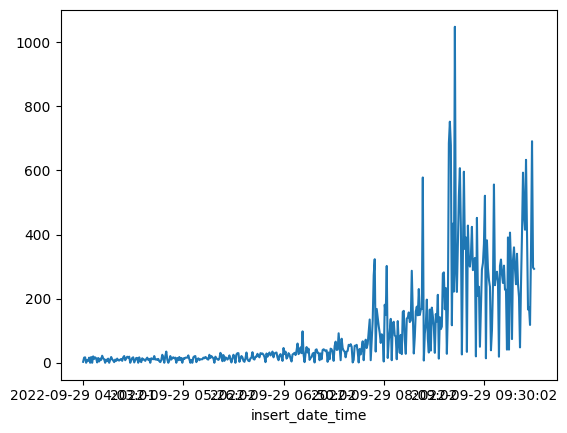

In [8]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

#### 4. Prepare training data

In [9]:
training_mean = df_daily_jumpsup.mean(numeric_only=True)
training_std = df_daily_jumpsup.std(numeric_only=True)
df_training_value = (df_daily_jumpsup - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 451


- Create sequences

In [10]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (164, 288, 1)


In [11]:
x_train

array([[[-6.35732417e-01],
        [-5.46312290e-01],
        [-5.39433818e-01],
        ...,
        [ 3.96541584e-03],
        [ 2.72225797e-01],
        [-6.01340060e-01]],

       [[-5.46312290e-01],
        [-5.39433818e-01],
        [-6.56367831e-01],
        ...,
        [ 2.72225797e-01],
        [-6.01340060e-01],
        [-1.54239424e-01]],

       [[-5.39433818e-01],
        [-6.56367831e-01],
        [-6.01340060e-01],
        ...,
        [-6.01340060e-01],
        [-1.54239424e-01],
        [ 2.51590383e-01]],

       ...,

       [[-6.35732417e-01],
        [-5.60069232e-01],
        [-4.36256748e-01],
        ...,
        [ 1.55291785e-01],
        [ 1.79236796e+00],
        [ 4.09665585e+00]],

       [[-5.60069232e-01],
        [-4.36256748e-01],
        [-5.80704646e-01],
        ...,
        [ 1.79236796e+00],
        [ 4.09665585e+00],
        [ 1.38653815e+00]],

       [[-4.36256748e-01],
        [-5.80704646e-01],
        [-6.15097003e-01],
        ...,
        

#### 5. Build a model
- input of shape (batch_size, sequence_length, num_features)

In [12]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

2022-11-23 16:11:17.903598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-23 16:11:17.903655: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-23 16:11:17.903677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (GELEE-IBD1): /proc/driver/nvidia/version does not exist
2022-11-23 16:11:17.903983: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 6. Train the model

In [13]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
2/2 [==============================] - 1s 204ms/step - loss: 0.5798 - val_loss: 1.1792
Epoch 2/50
2/2 [==============================] - 0s 37ms/step - loss: 0.5539 - val_loss: 1.1140
Epoch 3/50
2/2 [==============================] - 0s 48ms/step - loss: 0.5276 - val_loss: 1.0284
Epoch 4/50
2/2 [==============================] - 0s 60ms/step - loss: 0.4982 - val_loss: 0.9221
Epoch 5/50
2/2 [==============================] - 0s 44ms/step - loss: 0.4612 - val_loss: 0.7952
Epoch 6/50
2/2 [==============================] - 0s 45ms/step - loss: 0.4176 - val_loss: 0.6670
Epoch 7/50
2/2 [==============================] - 0s 45ms/step - loss: 0.3738 - val_loss: 0.5886
Epoch 8/50
2/2 [==============================] - 0s 45ms/step - loss: 0.3492 - val_loss: 0.5949
Epoch 9/50
2/2 [==============================] - 0s 45ms/step - loss: 0.3415 - val_loss: 0.5736
Epoch 10/50
2/2 [==============================] - 0s 38ms/step - loss: 0.3159 - val_loss: 0.5223
Epoch 11/50
2/2 [===========

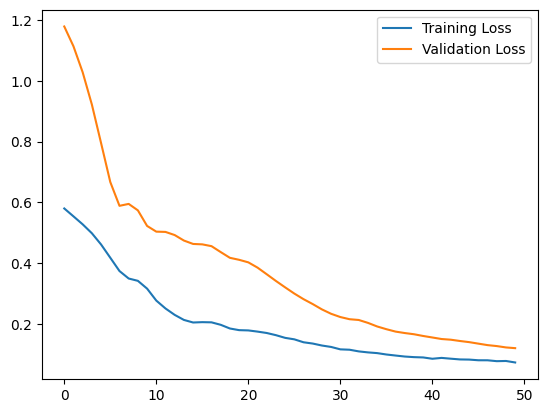

In [14]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

#### 7. Detecting anomalies
- 훈련 샘플에서 MAE 손실을 찾기
- 최대 MAE 손실 값을 찾음
    - 모델이 샘플을 재구성하려고 시도한 것 중 최악
    - 이것을 이상 탐지를 위한 임계값으로 만들 것임
- 샘플의 재구성 손실이 이 임계값보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론 할 수 있음
    - 이 샘플을 이상 항목으로 표시

6/6 [==============================] - 0s 5ms/step


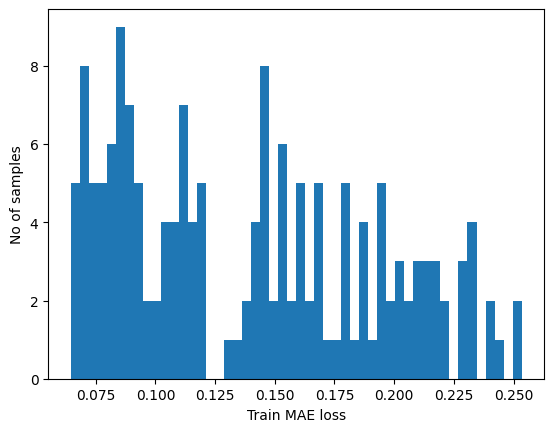

Reconstruction error threshold:  0.25339172192293835


In [15]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

- Compare recontruction

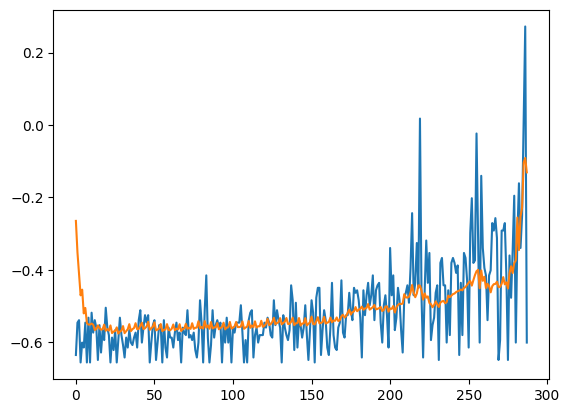

In [16]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

#### 8. Prepare test data

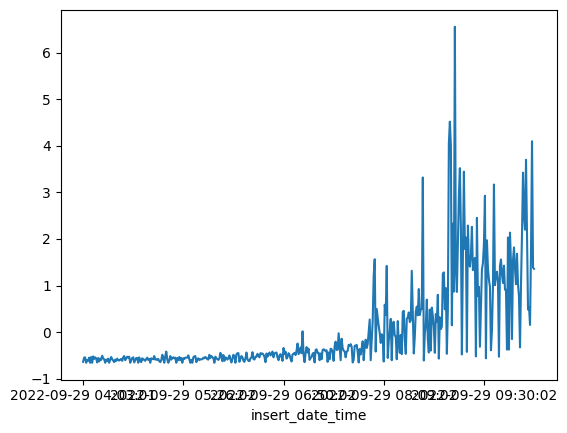

In [20]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [21]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (164, 288, 1)


In [30]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

6/6 [==============================] - 0s 4ms/step


In [32]:
test_mae_loss = test_mae_loss.reshape((-1))

In [33]:
test_mae_loss

array([0.06455557, 0.06451423, 0.06546361, 0.06701429, 0.07032584,
       0.06951685, 0.07108452, 0.06854616, 0.0675618 , 0.06942743,
       0.07056438, 0.06926591, 0.06904545, 0.07212205, 0.07491569,
       0.07310056, 0.07578179, 0.07860688, 0.07900541, 0.07767414,
       0.07580943, 0.07900152, 0.08086537, 0.08031032, 0.07827235,
       0.08077548, 0.08351721, 0.08212765, 0.08001744, 0.08429391,
       0.08412366, 0.08452057, 0.08279922, 0.08634222, 0.08643131,
       0.08790333, 0.08457629, 0.0862731 , 0.08777542, 0.0887463 ,
       0.08420521, 0.09028996, 0.09060575, 0.09088974, 0.08805356,
       0.09172074, 0.09179384, 0.09398179, 0.09156319, 0.09461004,
       0.09559811, 0.09688496, 0.10086   , 0.10472552, 0.10595503,
       0.10504037, 0.10053377, 0.10576817, 0.10936723, 0.10849431,
       0.10630435, 0.11057748, 0.11181149, 0.11046054, 0.10942058,
       0.11215459, 0.11367371, 0.11378866, 0.11085936, 0.1132316 ,
       0.11449532, 0.11298925, 0.11368686, 0.11991915, 0.11904

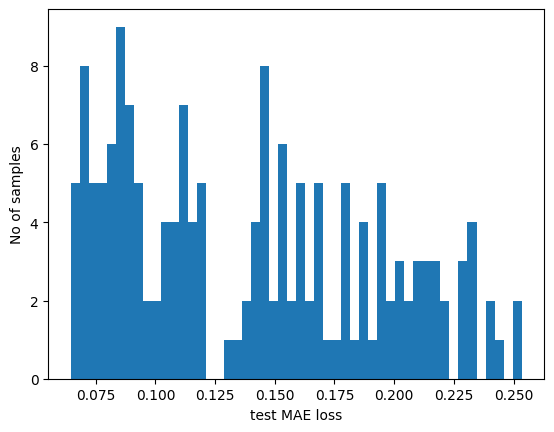

In [34]:

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [35]:
threshold

0.25339172192293835

In [37]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  0
Indices of anomaly samples:  (array([], dtype=int64),)


#### 9. Plot anomalies
- 난.. 비정상만 있어서 정상친구랑 비정상친구랑 비교하기가 어렵단으 ㅠㅠ

In [38]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

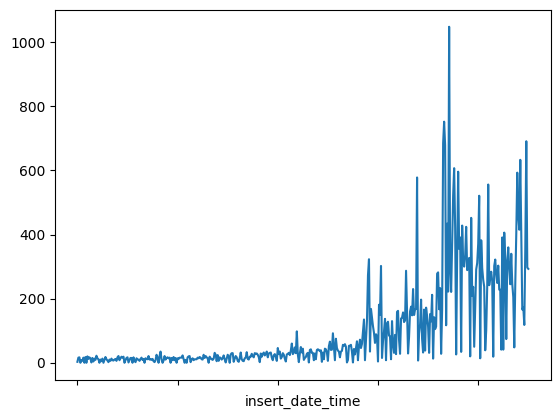

In [39]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()